# Step 1

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

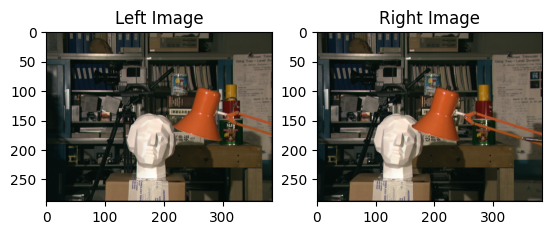

In [64]:
img = cv2.imread("tsukuba_left.png")
img_left = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_left = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)

img = cv2.imread("tsukuba_right.png")
img_right = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

# display side by side
plt.subplot(1, 2, 1)
plt.imshow(img_left)
plt.title("Left Image")
plt.subplot(1, 2, 2)
plt.imshow(img_right)
plt.title("Right Image")
plt.show()


In [65]:
def sum_of_absolute_differences(region, template):
    # Convert to int32 to prevent overflow
    return np.sum(np.abs(region.astype(np.int32) - template.astype(np.int32)))


# Step 2

In [66]:
img = cv2.imread("nose_left.png")
img_nose_left = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_nose_left = cv2.cvtColor(img_nose_left, cv2.COLOR_RGB2GRAY)

img = cv2.imread("nose1.png")
img_comp= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_comp = cv2.cvtColor(img_comp, cv2.COLOR_RGB2GRAY)

print(f"Nose 1 = {sum_of_absolute_differences(gray_nose_left, gray_comp)}")

img = cv2.imread("nose2.png")
img_comp= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_comp = cv2.cvtColor(img_comp, cv2.COLOR_RGB2GRAY)

print(f"Nose 2 = {sum_of_absolute_differences(gray_nose_left, gray_comp)}")

img = cv2.imread("nose3.png")
img_comp= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_comp = cv2.cvtColor(img_comp, cv2.COLOR_RGB2GRAY)

print(f"Nose 3 = {sum_of_absolute_differences(gray_nose_left, gray_comp)}")

Nose 1 = 1361
Nose 2 = 119
Nose 3 = 1490


# Step 3

In [67]:
def find_nose_in_span(span_img, template_img):
    """
    Finds the x-coordinate of the best match of template_img in span_img using SAD.
    
    span_img: 7xW image strip (grayscale or color)
    template_img: 7x7 template (grayscale or color)
    Returns: best_x, min_sad
    """
    # Convert to grayscale if needed
    if len(span_img.shape) == 3:
        span_gray = cv2.cvtColor(span_img, cv2.COLOR_BGR2GRAY)
    else:
        span_gray = span_img.copy()
        
    if len(template_img.shape) == 3:
        template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
    else:
        template_gray = template_img.copy()

    span_height, span_width = span_gray.shape
    template_height, template_width = template_gray.shape

    min_sad = float('inf')
    best_x = -1

    # Loop from left to right along the row
    for x in range(span_width - template_width + 1):
        # Extract current region of the same size as template
        region = span_gray[0:template_height, x:x + template_width]

        # Compute sum of absolute differences (SAD)
        sad = sum_of_absolute_differences(region, template_gray)

        if sad < min_sad:
            min_sad = sad
            best_x = x

    return best_x, min_sad


find_nose_in_span(cv2.imread("nose_span.png"), cv2.imread("nose_left.png"))

(132, np.int64(119))

In [68]:
def template_matching(tsukuba_left, tsukuba_right):
    left_gray = cv2.cvtColor(tsukuba_left, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(tsukuba_right, cv2.COLOR_BGR2GRAY)

    height, width = left_gray.shape
    disparity_map = np.zeros((height, width), dtype=np.float32)

    window_size = 7
    half_w = window_size // 2

    for y in range(half_w, height - half_w):
        for x in range(half_w, width - half_w):
            # Extract 7x7 template from left image
            template = left_gray[y-half_w:y+half_w+1, x-half_w:x+half_w+1]

            # Search only along the same row in right image
            search_row = right_gray[y-half_w:y+half_w+1, :]

            # Find best match in that row (your step 3 function)
            best_x, _ = find_nose_in_span(search_row, template)

            # Disparity = difference between left and right x-coordinates
            disparity = x - best_x
            if disparity >= 0:  # valid disparity (right image is shifted)
                disparity_map[y, x] = disparity

    return disparity_map
disparity = template_matching(img_left, img_right)

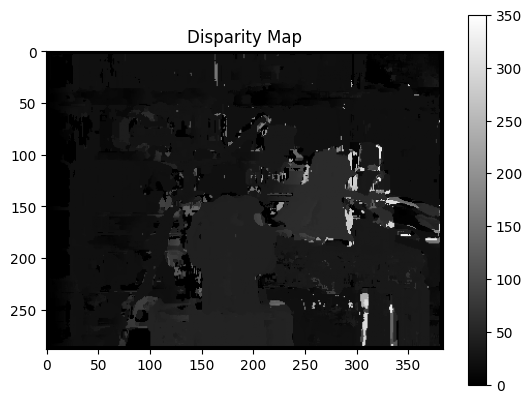

In [69]:
# show disparty map
plt.imshow(disparity, cmap='gray')
plt.colorbar()
plt.title("Disparity Map")
plt.show()